In [14]:
import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

# MNIST

##### Data preprocessing

In [4]:
# get data

data_path = '../data/'

transform = transforms.Compose([
    transforms.ToTensor()   # ToTensor() already normalizes pixel value from [0, 255] to [0, 1]
])

mnist_dataset = torchvision.datasets.MNIST(root=data_path, train=True, transform=transform, download=True)

# train val set
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

mnist_test_dataset = torchvision.datasets.MNIST(root=data_path, train=False, transform=transform, download=False)

In [5]:
# create dataloader
batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)  # no need to shuffle the valid and test set

##### Model

In [7]:
model = nn.Sequential()

# conv layer with 1 channel (greyscale), 32 5x5 kernels (outputs 32 feature maps), zero padding of 2 and stride of 2 to preserve output dimension
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  # 2x2 kernel pooling would subsample the image by halving its dimension

# conv layer with 32 channel (input of 32 feature maps from last conv layer), 64 5x5 kernels (outputs 64 feature maps), zero padding of 2 and stride of 2 to preserve output dimension
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

# flatten before connecting to FC layer (flatten to (batch_size, feature maps x H x W))
model.add_module('flatten', nn.Flatten())

# FC layer with input dimension num_featuremaps x H x W (64 x 7 x 7), 1024 units
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())

# output layer, 10 classes
model.add_module('fc2', nn.Linear(1024, 10))
# no need to explictly add softmax activation layer, because PyTorch CE loss already includes it

##### Train

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train(model, num_epochs, train_dl, valid_dl):
    # keep track of metrics for each epoch
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_val = [0] * num_epochs
    accuracy_hist_val = [0] * num_epochs

    for epoch in range(num_epochs):
        # switch to training to use dropout layer
        model.train()
        for x_batch, y_batch in train_dl:
            # forward predict
            pred = model(x_batch)
            # calculate error
            loss = loss_fn(pred, y_batch)
            # backward calculate gradient
            loss.backward()
            # update parameters using gradient
            optimizer.step()
            # reset gradient to 0
            optimizer.zero_grad()

            # track error
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)

            # track accuracy
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        # compute average for this epoch
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # switch to eval to not use dropout layer
        model.eval()

        # validation
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

                # track error
                loss_hist_val[epoch] += loss.item() * y_batch.size(0)

                # track accuracy
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_val[epoch] += is_correct.sum()

        # compute average for this epoch
        loss_hist_val[epoch] /= len(valid_dl.dataset)
        accuracy_hist_val[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_val[epoch]:.4f}')

    return loss_hist_train, loss_hist_val, accuracy_hist_train, accuracy_hist_val

In [12]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9871 val_accuracy: 0.9842
Epoch 2 accuracy: 0.9909 val_accuracy: 0.9879
Epoch 3 accuracy: 0.9944 val_accuracy: 0.9824
Epoch 4 accuracy: 0.9951 val_accuracy: 0.9874
Epoch 5 accuracy: 0.9966 val_accuracy: 0.9881
Epoch 6 accuracy: 0.9970 val_accuracy: 0.9866
Epoch 7 accuracy: 0.9975 val_accuracy: 0.9891
Epoch 8 accuracy: 0.9974 val_accuracy: 0.9913
Epoch 9 accuracy: 0.9975 val_accuracy: 0.9889
Epoch 10 accuracy: 0.9983 val_accuracy: 0.9880
Epoch 11 accuracy: 0.9986 val_accuracy: 0.9893
Epoch 12 accuracy: 0.9977 val_accuracy: 0.9895
Epoch 13 accuracy: 0.9987 val_accuracy: 0.9876
Epoch 14 accuracy: 0.9991 val_accuracy: 0.9884
Epoch 15 accuracy: 0.9982 val_accuracy: 0.9901
Epoch 16 accuracy: 0.9995 val_accuracy: 0.9911
Epoch 17 accuracy: 0.9989 val_accuracy: 0.9883
Epoch 18 accuracy: 0.9978 val_accuracy: 0.9889
Epoch 19 accuracy: 0.9991 val_accuracy: 0.9929
Epoch 20 accuracy: 0.9993 val_accuracy: 0.9891


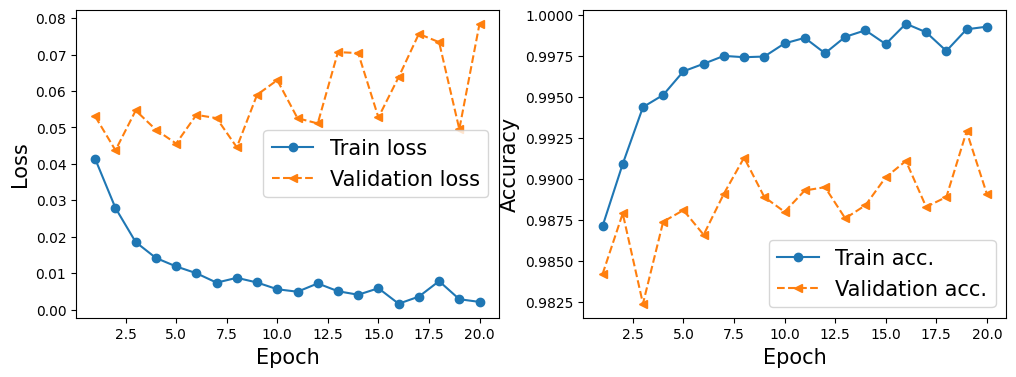

In [15]:
# plot
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [16]:
# eval on the test set
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9908


# Smile Classification

##### Data preprocessing